In [177]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def filter_contours(contours, min_size, max_size, image, min_influence):
    filtered_contours = []
    image_area = image.shape[0] * image.shape[1]  # Área total de la imagen

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # Calcula la influencia del contorno
        influence = area / image_area

        # Filtra contornos por tamaño, influencia, y posición
        if min_size <= area <= max_size and influence >= min_influence:
            # Si el contorno está muy cerca de los bordes, lo ignora
            if x > 12 and y > 12 and x + w < image.shape[1] - 12 and y + h < image.shape[0] - 12:
                filtered_contours.append(contour)

    return filtered_contours

def segment_contours(contours, image_shape):
    square_contours = []
    rectangular_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / (image_shape[0] * image_shape[1])
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 0.6 <= aspect_ratio <= 1.5 and area_ratio > 0.06:
            square_contours.append(contour)
        else:
            rectangular_contours.append(contour)
    return square_contours, rectangular_contours

# Function to filter contours that are inside other contours
def filter_inside_contours(contours):
    filtered_contours = []
    for contour in contours:
        parent_contour = None
        for other_contour in contours:
            if contour is not other_contour:
                # Verifica si todos los puntos están dentro del otro contorno
                if all(
                    cv2.pointPolygonTest(other_contour, (int(point[0][0]), int(point[0][1])), False) > 0
                    for point in contour
                ):
                    if parent_contour is None or cv2.contourArea(other_contour) > cv2.contourArea(parent_contour):
                        parent_contour = other_contour
        if parent_contour is None:
            filtered_contours.append(contour)
    return filtered_contours

def separate_contours_by_segments(contours, image_width):
    segments = []
    for i in range(4):
        segments.append([])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image_width // 4)
        segments[segment].append(contour)
    return segments

def get_orientation(contours):
    orientations = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > h:
            orientations.append('horizontal')
            # return 'Horizontal'
        else:
            orientations.append('vertical')
            # return 'Vertical'
    return orientations

def order_contours(segments):
    ordered_segments = []
    for segment in segments:
        if len(segment) <= 1:
            ordered_segments.append(segment)
        elif len(segment) == 2:
            x1, y1, w1, h1 = cv2.boundingRect(segment[0])
            x2, y2, w2, h2 = cv2.boundingRect(segment[1])
            if w1 > h1 and w2 > h2:
                if y1 < y2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
            elif w1 < h1 and w2 < h2:
                if x1 < x2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
        else:
            ordered_segments.append(segment)
    return ordered_segments

def get_area_ratio(contours, image):
    image_area = (image.shape[0] * image.shape[1]) / 4
    area_ratios = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / image_area
        area_ratios.append(round(area_ratio, 3))
    return area_ratios

def get_segment_info(contours, image):
    segments = []
    for i in range(4):
        segments.append([])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image.shape[1] // 4)
        segments[segment].append(contour)
    # Order the contours in each segment
    ordered_segments = order_contours(segments)
    # Get the orientation of the contours
    orientations = []
    for i in range(4):
        orientations.append(get_orientation(ordered_segments[i]))

    # Get the area ratio of the contours
    area_ratios = []
    for i in range(4):
        area_ratios.append(get_area_ratio(ordered_segments[i], image))
        
    # Get the relation between the area of the contours
    area_ratios_relation = []
    for i, segment in enumerate(ordered_segments):
        if len(segment) == 2:
            area1 = cv2.contourArea(segment[0])
            area2 = cv2.contourArea(segment[1])
            area_ratio = round(area1 / area2, 3)
            area_ratios_relation.append(area_ratio)
        else:
            area_ratios_relation.append(None)

    # Get the information of the segments
    segment_info = []
    for i in range(4):
        segment_info.append({'num_contours': len(ordered_segments[i]), 'orientation': orientations[i], 'area_ratios': area_ratios[i], 'area_ratios_relation': area_ratios_relation[i]})
    return segment_info

# Decode segment number given the information of the segments
def decode_number(segment_info):
    segment_number = ''
    for i in range(4):
        # Validar si el segmento tiene la estructura esperada
        if i >= len(segment_info):
            segment_number += 'X'
            continue
        
        num_contours = segment_info[i]['num_contours']
        orientation = segment_info[i]['orientation']
        area_ratios = segment_info[i]['area_ratios']
        area_ratios_relation = segment_info[i]['area_ratios_relation']
        if num_contours == 0:
            segment_number += '0'
        elif num_contours == 1:
            if orientation[0] == 'horizontal':
                segment_number += '8'
            else:
                if area_ratios[0] < 0.15:
                    segment_number += '1'
                else:
                    segment_number += '5'
        elif num_contours == 2:
            if orientation[0] == 'horizontal':
                if area_ratios_relation > 1.2:
                    segment_number += '7'
                elif area_ratios_relation < 0.8:
                    segment_number += '9'
                else:
                    segment_number += '3'
            else:
                if area_ratios_relation > 1.2:
                    segment_number += '6'
                elif area_ratios_relation < 0.8:
                    segment_number += '4'
                else:
                    segment_number += '2'
        else:
            segment_number += 'X'
    return segment_number

segment_info_global = []

def process_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_blur = cv2.GaussianBlur(image_gray, (11, 11), 0)
    image_thresh = cv2.adaptiveThreshold(image_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    image_eroded = cv2.erode(image_thresh, np.ones((3, 3), np.uint8), iterations=1)
    contours, _ = cv2.findContours(image_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and segment contours
    filtered_contours = filter_contours(contours, 200, 25000, image_eroded, 0.01)
    _, rectangular_contours = segment_contours(filtered_contours, image_eroded.shape)
    rectangular_contours = filter_inside_contours(rectangular_contours)

    # Separate and process segments
    segments = separate_contours_by_segments(rectangular_contours, image.shape[1])
    ordered_segments = order_contours(segments)

    # Extract segment info
    segment_info = []
    for segment in ordered_segments:
        num_contours = len(segment)
        orientations = ['horizontal' if cv2.boundingRect(c)[2] > cv2.boundingRect(c)[3] else 'vertical' for c in segment]
        area_ratios = get_area_ratio(segment, image)
        if len(segment) == 2:
            area_ratio_relation = round(cv2.contourArea(segment[0]) / cv2.contourArea(segment[1]), 3)
        else:
            area_ratio_relation = None
        segment_info.append({
            'num_contours': num_contours,
            'orientation': orientations,
            'area_ratios': area_ratios,
            'area_ratios_relation': area_ratio_relation
        })

        # Almacenar segment_info de esta imagen en la matriz global
    segment_info_global.append(segment_info)

    return decode_number(segment_info)


### Matriz de confusión

In [178]:
# Inicializar la matriz de confusión con 11 clases (0-9 y X)
num_clases = 11  # Clases 0-9 y "X"
matriz_confusion = np.zeros((10, num_clases), dtype=int)

# Lista para almacenar las imágenes mal predichas
imagenes_mal_predichas = []

# Procesar las imágenes en el directorio
folder_path = "Processed Images"
# Ruta de la carpeta de destino para las imágenes mal predichas
carpeta_destino = "ImagenesProblematicas"
os.makedirs(carpeta_destino, exist_ok=True)  # Crear la carpeta si no existe

archivos = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

for file_name in archivos:
    # Leer la imagen
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    # Extraer los primeros 4 dígitos del nombre del archivo
    digitos_imagen = file_name[:4]  # Los primeros 4 dígitos del nombre
    digitos_imagen_array = [int(d) for d in digitos_imagen]

    # Predecir los 4 dígitos utilizando tu función `process_image`
    codigo_segmentos = process_image(image_path)

    # Validar que el resultado tenga exactamente 4 caracteres
    if len(codigo_segmentos) < 4:
        codigo_segmentos += "X" * (4 - len(codigo_segmentos))  # Rellenar con 'X' si es necesario
    codigo_segmentos_array = []
    for char in codigo_segmentos:
        if char.isdigit():
            codigo_segmentos_array.append(int(char))
        else:
            codigo_segmentos_array.append(10)  # Asignar 'X' como clase 11

    # Comparar los códigos
    for j in range(4):  # Comparar los 4 dígitos
        fila = digitos_imagen_array[j]
        columna = codigo_segmentos_array[j]
        matriz_confusion[fila, columna] += 1

        # Si no coinciden, agregar el nombre de la imagen y la posición del error
        if fila != columna:
            imagenes_mal_predichas.append({
                "archivo": file_name,
                "posición": j + 1,
                "real": fila,
                "predicción": columna
            })
    # Si la imagen está en las mal predichas, moverla a la carpeta problemática
    if any(item["archivo"] == file_name for item in imagenes_mal_predichas):
        destino_imagen = os.path.join(carpeta_destino, file_name)


# Mostrar las imágenes mal predichas
print("Imágenes mal predichas:")
for error in imagenes_mal_predichas:
    real_label = str(error["real"]) if error["real"] < 10 else "X"
    pred_label = str(error["predicción"]) if error["predicción"] < 10 else "X"
    print(f"Archivo: {error['archivo']}, Posición: {error['posición']}, Real: {real_label}, Predicción: {pred_label}")

# Crear un heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(matriz_confusion, interpolation='nearest', cmap='viridis')
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")

# Etiquetas de clases
x_labels = [str(i) for i in range(10)] + ["X"]
y_labels = [str(i) for i in range(10)]
plt.xticks(np.arange(num_clases), x_labels)
plt.yticks(np.arange(10), y_labels)

# Mostrar los valores en la matriz
for i in range(10):
    for j in range(num_clases):
        plt.text(j, i, str(matriz_confusion[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'Processed Images\\0532.jpg' -> 'ImagenesProblematicas\\0532.jpg'

### Tasa de acierto del clasificador

In [157]:
# Calcular accuracy
correctos = np.sum(np.diag(matriz_confusion[:, :10]))  # Valores correctos en las primeras 10 columnas
total = np.sum(matriz_confusion)  # Total de predicciones
accuracy = correctos / total if total > 0 else 0

# Calcular el sumatorio de todos los números analizados
total_numeros_analizados = np.sum(matriz_confusion)
aciertos = np.sum(np.diagonal(matriz_confusion))

# Mostrar el sumatorio de los aciertos
print(f"Total de aciertos (diagonal): {aciertos}")

# Mostrar el sumatorio
print(f"Total de números analizados: {total_numeros_analizados}")

# Mostrar accuracy
print(f"Tasa de acierto del clasificador: {accuracy * 100:.2f}%")

Total de aciertos (diagonal): 4
Total de números analizados: 4
Tasa de acierto del clasificador: 100.00%


### Confusiones

In [158]:
# Función para obtener las confusiones más frecuentes
def obtener_confusiones(matriz_confusion):
    confusiones = []
    for i in range(matriz_confusion.shape[0]):  # Recorrer filas (valores reales)
        for j in range(matriz_confusion.shape[1]):  # Recorrer columnas (predicciones)
            if i != j and matriz_confusion[i, j] > 0:  # Evitar la diagonal principal
                confusiones.append(((i, j), matriz_confusion[i, j]))
    
    # Ordenar por la cantidad de confusiones en orden descendente
    confusiones.sort(key=lambda x: x[1], reverse=True)
    return confusiones

# Obtener las confusiones más frecuentes
confusiones_mas_frecuentes = obtener_confusiones(matriz_confusion)

# Imprimir las confusiones
print("Confusiones más frecuentes:")
for (real, pred), cantidad in confusiones_mas_frecuentes:
    real_label = str(real) if real < 10 else "X"
    pred_label = str(pred) if pred < 10 else "X"
    print(f"Real: {real_label}, Predicción: {pred_label}, Cantidad: {cantidad}")

Confusiones más frecuentes:


### Diagrama de dispersión

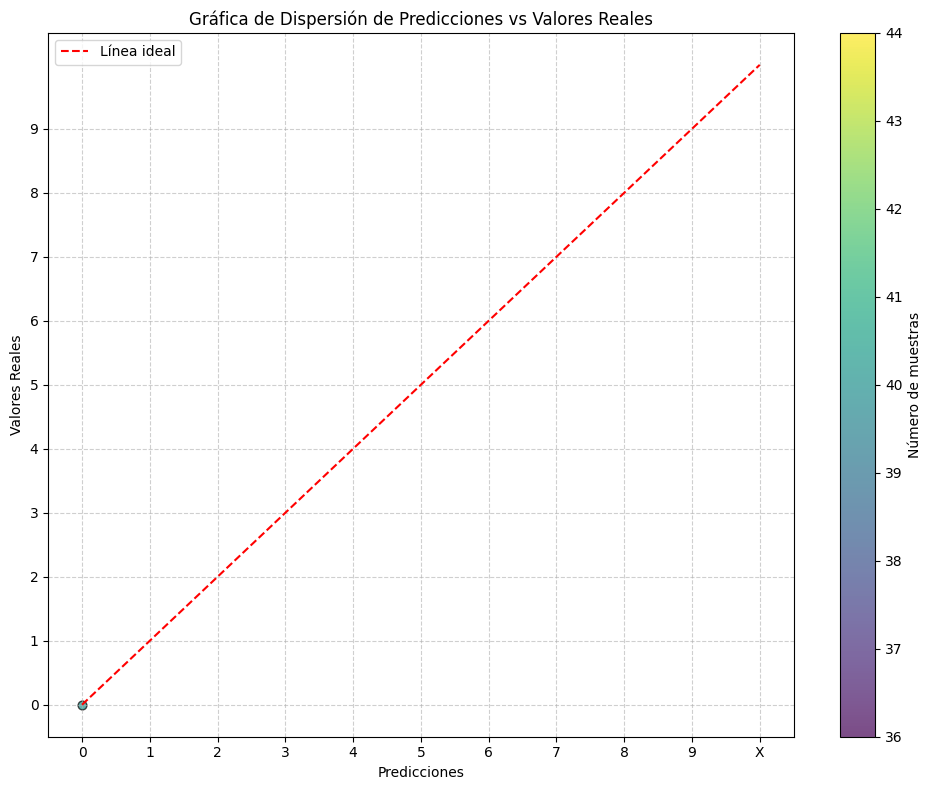

In [159]:
# Crear los datos para la gráfica de dispersión
x = []
y = []
sizes = []

# Recorrer la matriz de confusión
for i in range(10):  # Valores reales (eje y)
    for j in range(num_clases):  # Predicciones (eje x)
        if matriz_confusion[i, j] > 0:  # Solo considerar puntos con datos
            x.append(j)  # Predicción
            y.append(i)  # Valor real
            sizes.append(matriz_confusion[i, j] * 10)  # Escalar el tamaño

# Crear la figura
plt.figure(figsize=(10, 8))

# Dibujar la línea ideal (y = x)
plt.plot(range(11), range(11), linestyle='--', color='red', label='Línea ideal')

# Crear la gráfica de dispersión
scatter = plt.scatter(x, y, s=sizes, c=sizes, cmap='viridis', alpha=0.7, edgecolor='k')

# Etiquetas y leyenda
plt.colorbar(scatter, label='Número de muestras')
plt.title('Gráfica de Dispersión de Predicciones vs Valores Reales')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.xticks(range(11), [str(i) for i in range(10)] + ["X"])
plt.yticks(range(10), [str(i) for i in range(10)])
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Diagrama dispersión orientación vs area_ratios

### Diagrama de cajas

In [160]:
# Agrupar los valores de area_ratios según la orientación
area_ratios_horizontal = [ratio for i, ratio in enumerate(area_ratios) if orientations[i] == 1]  # Horizontal
area_ratios_vertical = [ratio for i, ratio in enumerate(area_ratios) if orientations[i] == 0]  # Vertical

# Crear el diagrama de cajas
plt.figure(figsize=(8, 6))
plt.boxplot(
    [area_ratios_horizontal, area_ratios_vertical],
    labels=["Horizontal", "Vertical"],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red')
)

# Configurar el gráfico
plt.title("Diagrama de Cajas - Relación de Áreas por Orientación")
plt.ylabel("Relación de Áreas (area_ratios)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

NameError: name 'area_ratios' is not defined

### Matriz de correlación de las características

C:\Users\paufe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\paufe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


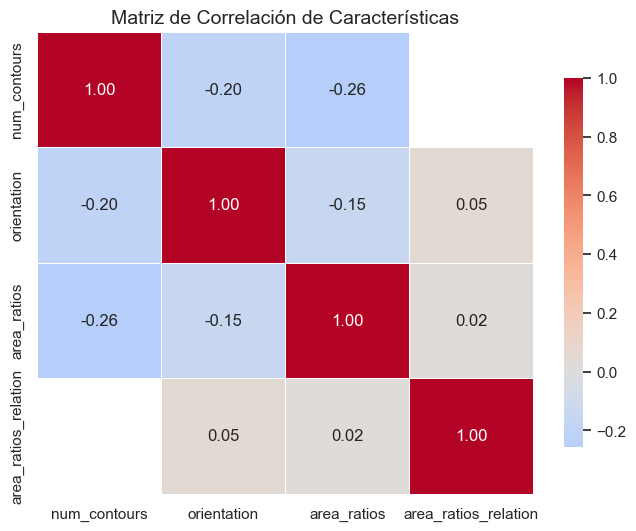

In [ ]:
# Función para convertir las características en formato numérico
def process_features(segment_info):
    num_contours = []
    orientations = []
    area_ratios = []
    area_ratios_relation = []

    for segment in segment_info:
        # Número de contornos
        num_contours.append(segment['num_contours'])
        
        # Convertir orientaciones a valores numéricos: 'horizontal' -> 0, 'vertical' -> 1
        orientation_values = [1 if o == 'vertical' else 0 for o in segment['orientation']]
        orientations.append(np.mean(orientation_values))  # Usamos el promedio de orientaciones

        # Área ratios (promedio)
        area_ratios.append(np.mean(segment['area_ratios']))
        
        # Área ratio relación
        area_ratios_relation.append(segment['area_ratios_relation'])

    return np.array([num_contours, orientations, area_ratios, area_ratios_relation]).T

# Preparar las características
features = process_features(segment_info_global)

# Crear un DataFrame para visualización
df = pd.DataFrame(features, columns=['num_contours', 'orientation', 'area_ratios', 'area_ratios_relation'])

# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Configuración del estilo de Seaborn para una visualización más atractiva
sns.set(style='white', palette='muted')

# Crear la figura de la matriz de correlación
plt.figure(figsize=(8, 6))

# Usar seaborn para crear el heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": 0.8})

# Título del gráfico
plt.title("Matriz de Correlación de Características", fontsize=14)

# Mostrar el gráfico
plt.show()

Clases únicas en 'real_label': [0 1 2]


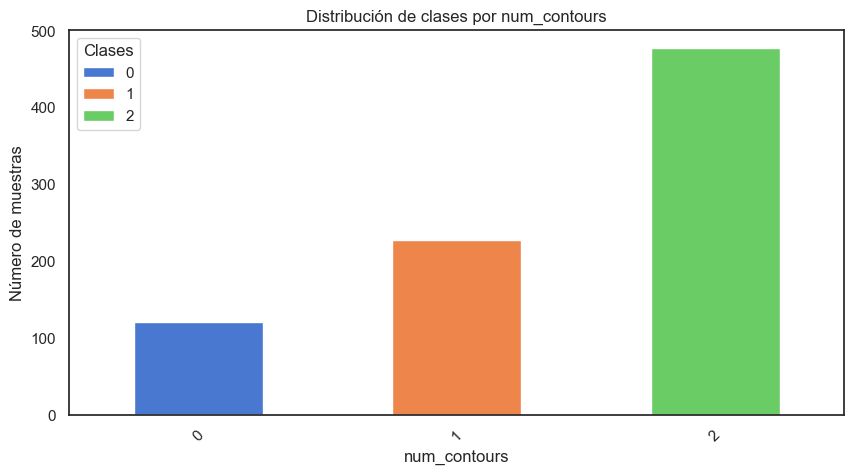

In [114]:
# Si segment_info_global es una lista, conviértela en un DataFrame
segment_info_global = pd.DataFrame(segment_info_global)

# Asegúrate de que 'real_label' sea la columna correcta
real_label = 'num_contours'  # Cambiar por el nombre correcto de la columna

# Verificar las clases únicas en real_label
print("Clases únicas en 'real_label':", segment_info_global[real_label].unique())

# Agrupar los datos por 'num_contours' y 'real_label' y contar el tamaño de cada grupo
class_by_num_contours = segment_info_global.groupby(['num_contours', real_label]).size().unstack()

# Crear el gráfico de barras apiladas
class_by_num_contours.plot(kind='bar', stacked=True, figsize=(10, 5))

# Establecer título y etiquetas
plt.title('Distribución de clases por num_contours')
plt.xlabel('num_contours')
plt.ylabel('Número de muestras')
plt.legend(title='Clases')

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()